# Feature Visualization with Compositional Pattern Producing Networks

This tutorial demonstrates how to perform feature visualization using
[compositional pattern producing networks](https://en.wikipedia.org/wiki/Compositional_pattern-producing_network) with Captum's optim module, based on the [Differentiable Image Parameterizations](https://distill.pub/2018/differentiable-parameterizations/#section-xy2rgb) research paper.

In [ ]:
%load_ext autoreload
%autoreload 2

from typing import Callable, List, Optional, Tuple, Union

import warnings
warnings.simplefilter("ignore", UserWarning)

import captum.optim as opt
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = opt.models.googlenet(pretrained=True).to(device)

## Setup

Below we define a visualization helper function, and multiple activation functions to try.

In [ ]:
def visualize(
    model: torch.nn.Module,
    loss_fn: opt.loss.Loss,
    image: opt.images.ImageParameterization,
    n_iter: int = 512,
    lr: float = 0.004,
) -> None:
    transforms = opt.transforms.TransformationRobustness()
    obj = opt.InputOptimization(model, loss_fn, image, transform=transforms)
    history = obj.optimize(opt.optimization.n_steps(n_iter), lr=lr)


class CompositeActivation(torch.nn.Module):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.atan(x)
        return torch.cat([x / 0.67, (x * x) / 0.6], 1)


class CompositeActivationUnBiased(torch.nn.Module):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.atan(x)
        return torch.cat([x / 0.67, (x * x - 0.45) / 0.396], 1)


class ReLUNormalized(torch.nn.Module):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.nn.functional.relu(x)
        return (x - 0.40) / 0.58


class AbsActivation(torch.nn.Module):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.abs(x)

## CPPN XY To RGB Parameterization

Next we define an ImageParameterization that passes a 2 channel XY coordinate input through a compositional pattern producing network (CPPN) to produce a 3 channel RGB image.

In [ ]:
class CPPNParam(opt.images.ImageParameterization):
    """
    CPPN model: [X, Y] --> [R, G, B]

    See here for more information:
    https://distill.pub/2018/differentiable-parameterizations/#section-xy2rgb
    https://github.com/tensorflow/lucid/blob/master/lucid/optvis/param/cppn.py
    https://github.com/greentfrapp/lucent/blob/dev/lucent/optvis/param/cppn.py
    """

    def __init__(
        self,
        size: Tuple[int, int] = (224, 224),
        channels: int = 3,
        batch: int = 1,
        num_channels: int = 24,
        num_layers: int = 8,
        activ_fn: Callable[[torch.Tensor], torch.Tensor] = CompositeActivation,
        normalize: bool = False,
    ) -> None:
        """
        Args:

            size (tuple of int, optional): The desired image size to use, in the
                format of: (height, width).
                Default: (224, 224)
            batch (int, optional): The number of CPPN models to train & use.
                Default: 1
            channels (int, optional): The number of to use in channels in the
                output image.
                Default: 3
            num_hidden_channels (int, optional): The number of channels to use in the
                CPPN model layers.
                Default: 24
            num_layers (int, optional): The number of layers to use in the CPPN model.
                Default: 8
            activ_fn (callable, optional):
                Default: CompositeActivation
            normalize (bool, optional): Whether or not to use instance norm layers in
                the CPPN model.
                Default: False
        """
        super().__init__()
        self.register_buffer("xy_input", self._create_xy_input(size))
        self.num_hidden_channels = num_hidden_channels
        self.cppn = torch.nn.ModuleList(
            [
                self._create_model(
                    num_hidden_channels, num_layers, activ_fn, normalize, channels
                )
                for _ in range(batch)
            ]
        )

    def _create_xy_input(self, size: Tuple[int, int]) -> torch.Tensor:
        """
        Create an input to use for training CPPN models.

        Args:

            size (tuple of int, optional): The desired image size to use, in the
                format of: (height, width).
                Default: (224, 224)

        Returns:
            xy_input (torch.Tensor): An NCHW tensor with 2 channels for use in a
                CPPN model.
        """
        r = 3**0.5
        h, w = torch.linspace(-r, r, size[0]), torch.linspace(-r, r, size[1])
        w = w.view(-1, 1).repeat(1, h.shape[0])
        h = h.view(1, -1).repeat(w.shape[0], 1)
        return torch.stack([h, w], dim=0).unsqueeze(0)

    def resize_input(self, size: Tuple[int, int]) -> torch.Tensor:
        """
        Change the output size's height and width dimensions.

        Args:

            size (tuple of int, optional): The desired image size to use, in the
                format of: (height, width).
                Default: (224, 224)
        """
        self.xy_input = self._create_xy_input(size).to(self.xy_input.device)

    def _create_model(
        self,
        num_channels: int,
        num_layers: int,
        activ_fn: Callable[[torch.Tensor], torch.Tensor],
        instance_norm: bool = False,
        out_channels: int = 3,
        affine: bool = True,
        bias: bool = True,
    ) -> torch.nn.Module:
        """
        Create a CPPN model.

        Args:

            num_channels (int, optional): The number of channels to use in the CPPN
                model layers.
                Default: 24
            num_layers (int, optional): The number of layers to use in the CPPN model.
                Default: 8
            activ_fn (callable, optional):
                Default: CompositeActivation
            instance_norm (bool, optional): Whether or not to use instance norm layers
                in the CPPN model.
                Default: False
            out_channels (int, optional): The number of to use in channels in the
                output image.
                Default: 3
            affine (bool, optional): If instance_norm is True, then whether or not to
               enable affine.
               Default: True
            bias (bool, optional): Whether or not to use bias in nn.Conv2d layers.
               Default: True

        """
        model = [
            torch.nn.Conv2d(
                in_channels=2, out_channels=num_channels, kernel_size=1, bias=bias
            )
        ]
        if instance_norm:
            model += [torch.nn.InstanceNorm2d(num_channels, affine=affine)]
        model += [activ_fn()]
        for l in range(num_layers - 1):
            model += [
                torch.torch.nn.LazyConv2d(
                    out_channels=num_channels,
                    kernel_size=1,
                    bias=bias,
                )
            ]
            if instance_norm:
                model += [torch.nn.LazyInstanceNorm2d(affine=affine)]
            model += [activ_fn()]
        model += [
            torch.nn.LazyConv2d(out_channels=out_channels, kernel_size=1, bias=bias)
        ]
        model = torch.nn.Sequential(*model)
        model(self.xy_input)  # Set Lazy layer shapes
        model.apply(self._cppn_normal)
        return model

    def _cppn_normal(self, l: torch.nn.Module) -> None:
        """
        Normalize Conv2d weights based on the number of channels.

        Args:

            l (nn.Module): An nn.Module layer instance.
        """
        if type(l) == torch.nn.Conv2d or type(l) == torch.nn.LazyConv2d:
            l.weight.data.normal_(0, (1.0 / self.num_channels) ** (1 / 2))
            if l.bias is not None:
                torch.nn.init.zeros_(l.bias)

    @property
    def models(self) -> torch.nn.ModuleList:
        """
        Returns:
            cppn_models (torch.nn.ModuleList): The list of CPPN models.
        """
        return self.cppn

    def forward(self) -> torch.Tensor:
        """
        Returns:
            **output** (torch.tensor): An NCHW image tensor.
        """
        return torch.cat([m(self.xy_input) for m in self.cppn], 0)

## Rendering

### Different Activation Types

#### CompositeActivation

  0%|          | 0/512 [00:00<?, ? step/s]

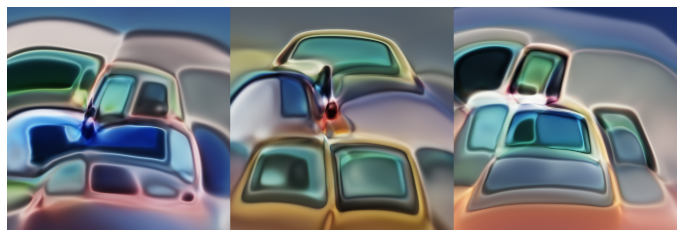

In [ ]:
parameterization = CPPNParam((224, 224), batch=3, activ_fn=CompositeActivation)
image = opt.images.NaturalImage(parameterization=parameterization).to(device)

loss_fn = opt.loss.ChannelActivation(model.mixed4b.conv_3x3, 77)

visualize(model, loss_fn, image, n_iter=512, lr=0.004)

image().show(images_per_row=3, figsize=(12, 12))

#### CompositeActivationUnBiased

  0%|          | 0/512 [00:00<?, ? step/s]

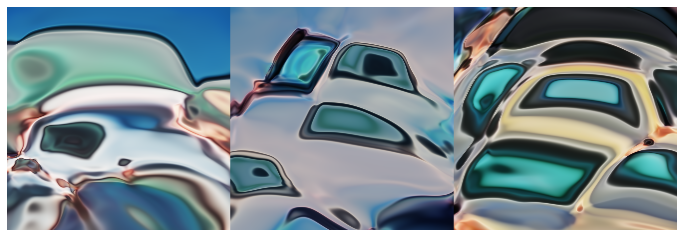

In [ ]:
parameterization = CPPNParam((224, 224), batch=3, activ_fn=CompositeActivationUnBiased)
image = opt.images.NaturalImage(parameterization=parameterization).to(device)

loss_fn = opt.loss.ChannelActivation(model.mixed4b.conv_3x3, 77)

visualize(model, loss_fn, image, n_iter=512, lr=0.004)

image().show(images_per_row=3, figsize=(12, 12))

#### ReLUNormalized

  0%|          | 0/512 [00:00<?, ? step/s]

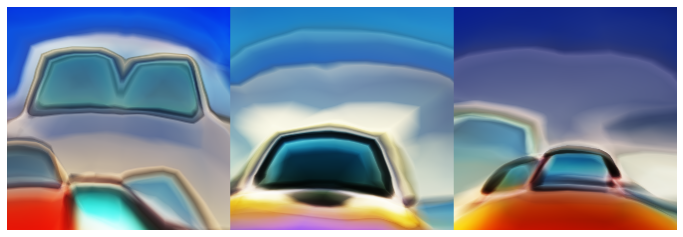

In [ ]:
parameterization = CPPNParam((224, 224), batch=3, activ_fn=ReLUNormalized)
image = opt.images.NaturalImage(parameterization=parameterization).to(device)

loss_fn = opt.loss.ChannelActivation(model.mixed4b.conv_3x3, 77)

visualize(model, loss_fn, image, n_iter=512, lr=0.004)

image().show(images_per_row=3, figsize=(12, 12))

#### AbsActivation

  0%|          | 0/512 [00:00<?, ? step/s]

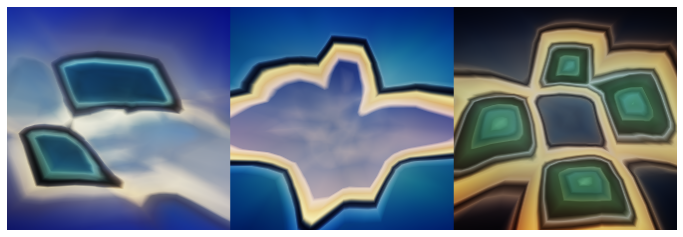

In [ ]:
parameterization = CPPNParam((224, 224), batch=3, activ_fn=AbsActivation)
image = opt.images.NaturalImage(parameterization=parameterization).to(device)

loss_fn = opt.loss.ChannelActivation(model.mixed4b.conv_3x3, 77)

visualize(model, loss_fn, image, n_iter=512, lr=0.004)

image().show(images_per_row=3, figsize=(12, 12))

### Resizing

As CPPN models work with coordinates rather than pixels, we can make already trained CPPNs output different sizes without requiring any retraining. As such, CPPN models have infinite resolution.

  0%|          | 0/512 [00:00<?, ? step/s]

Image Shape: torch.Size([2, 3, 128, 128])


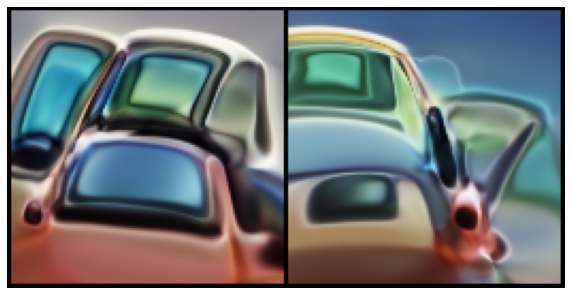


Image Shape: torch.Size([2, 3, 1024, 1024])


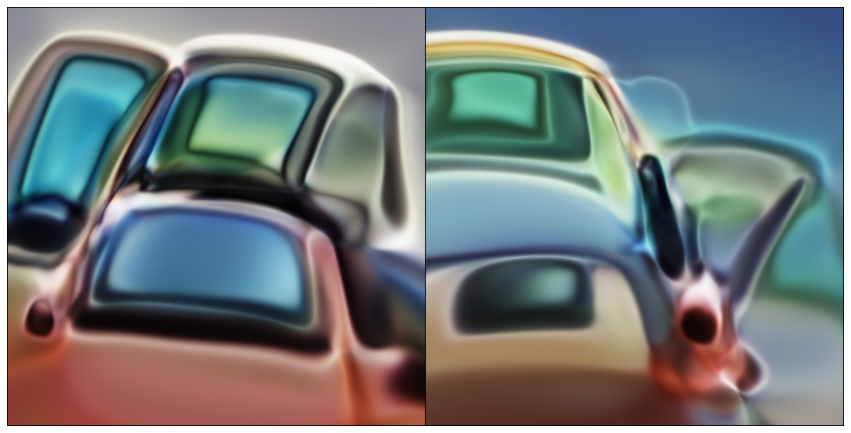

In [ ]:
# Setup low resolution 128x128 image rendering
parameterization = CPPNParam((128, 128), batch=2, activ_fn=CompositeActivation)
image = opt.images.NaturalImage(parameterization=parameterization).to(device)

loss_fn = opt.loss.ChannelActivation(model.mixed4b.conv_3x3, 77)

visualize(model, loss_fn, image, n_iter=512, lr=0.004)

print("Image Shape:", image().shape)
image().show(images_per_row=2, figsize=(10, 10))

# Resize model inputs
image.parameterization.resize_input((1024, 1024))

print("\nImage Shape:", image().shape)
image().show(images_per_row=2, figsize=(15, 15))

### Different Layers

The unique artistic style that CPPN models produce can be seen below across multiple examples.

  0%|          | 0/512 [00:00<?, ? step/s]

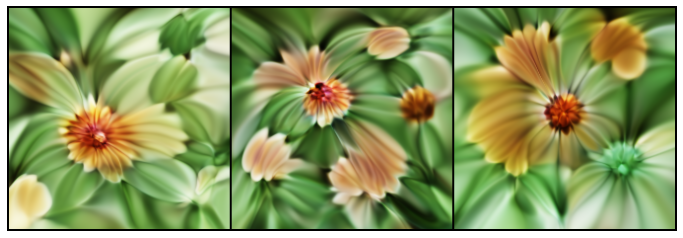

  0%|          | 0/512 [00:00<?, ? step/s]

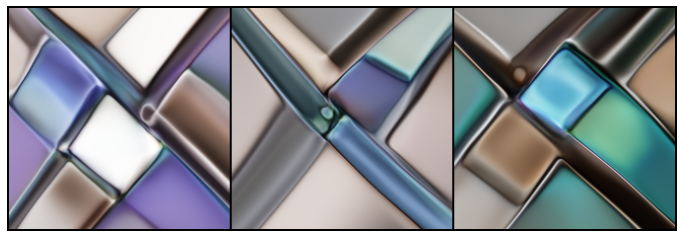

  0%|          | 0/512 [00:00<?, ? step/s]

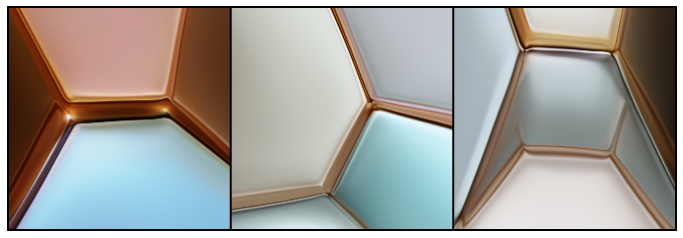

  0%|          | 0/512 [00:00<?, ? step/s]

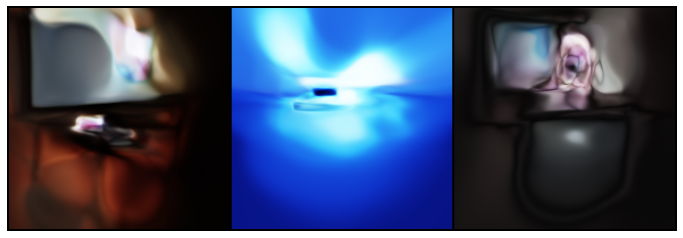

  0%|          | 0/512 [00:00<?, ? step/s]

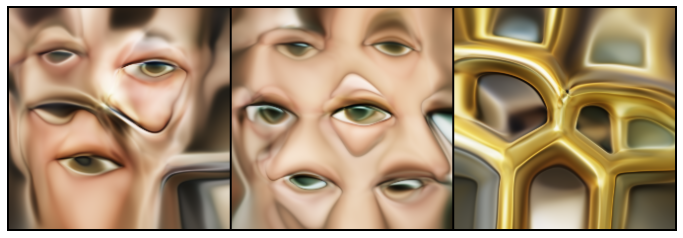

  0%|          | 0/512 [00:00<?, ? step/s]

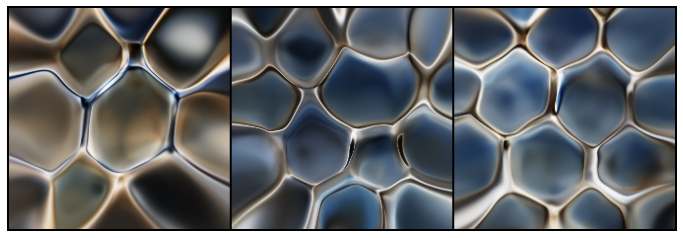

  0%|          | 0/512 [00:00<?, ? step/s]

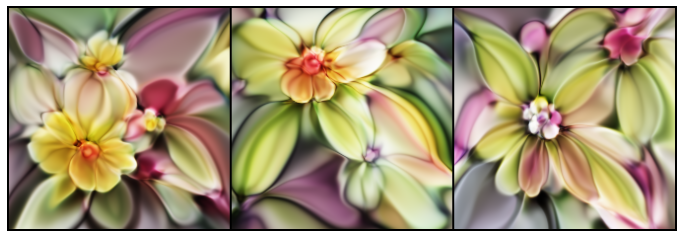

In [ ]:
interesting_targets = [
    [model.mixed4b.pool_proj, 16],
    [model.mixed4a.pool_proj, 52],
    [model.mixed4c.pool_proj, 5],
    [model.fc, 316],
    [model.mixed4d.conv_3x3_reduce, 114],
    [model.mixed4e.conv_3x3, 120],
    [model.mixed4d.conv_3x3_reduce, 139],
]


# Render each target in interesting_targets
for target, channel_index in interesting_targets:
    parameterization = CPPNParam((224, 224), batch=3, activ_fn=CompositeActivation)
    image = opt.images.NaturalImage(parameterization=parameterization).to(device)

    loss_fn = opt.loss.ChannelActivation(target, channel_index)

    visualize(model, loss_fn, image, n_iter=512, lr=0.004)

    image().show(images_per_row=3, figsize=(12, 12))